# Система оценки риска ДТП

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">
    
**Цель проекта**  
Разработать систему оценки риска ДТП для каршеринговой компании, которая сможет предсказывать вероятность аварии на выбранном маршруте на основе исторических данных. Система должна предупреждать водителей о высоком уровне риска и предоставлять рекомендации по альтернативным маршрутам.

**Задачи проекта**  

**1. Исследование данных**  
- Провести первичный анализ таблиц (`collisions`, `parties`, `vehicles`) для проверки их полноты и связей  
- Изучить временные тенденции (количество ДТП по месяцам)  
- Сформулировать и решить 6+ аналитических задач для команды

**2. Подготовка данных для модели**  
- Сформировать выборку по условиям:  
  - Участник ДТП — автомобиль  
  - Повреждения — значимые, кроме царапин   
  - Данные за 2012 год  
- Учесть возраст автомобиля как ключевой фактор  
- Провести предобработку: очистку, кодирование категориальных признаков, масштабирование  

**3. Построение и оценка модели**  
- Обучить 3 модели: 
  - Логистическая регрессия
  - Случайный лес  
  - Градиентный бустинг 
- Выбрать метрику (F1 или ROC-AUC) с учетом возможного дисбаланса классов  
- Подобрать гиперпараметры  
- Проанализировать важность факторов, влияющих на риск ДТП  

**4. Анализ результатов**  
- Визуализировать матрицу ошибок и ключевые метрики (precision, recall)  
- Исследовать влияние критических факторов на целевую переменную  
- Предложить технические решения для снижения риска  

**5. Выводы и рекомендации**  
- Оценить возможность создания системы оценки риска на основе модели  
- Определить дополнительные факторы, которые стоит учитывать     

**Итоговый результат**  
Обоснование возможности предсказания ДТП, список значимых факторов и рекомендации по оснащению автомобилей для снижения рисков.
    
    

## Импорты и необходимые функции

In [1]:
!pip install sqlalchemy

In [2]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install catboost -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install imblearn -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install optuna -q

Note: you may need to restart the kernel to use updated packages.


In [7]:
#Импортируем необходимые библиотеки для работы 
import pandas as pd
from math import *
import numpy as np
from scipy import stats as st
from sqlalchemy import create_engine 

# Метрики и оОбработка данных
from imblearn.combine import SMOTETomek
from sklearn.metrics import (roc_auc_score, f1_score, roc_curve, auc, confusion_matrix,
                             accuracy_score, precision_score, recall_score, RocCurveDisplay,classification_report
                            )
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import (StandardScaler, OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder)

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MultiLabelBinarizer
import optuna
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Графическое отображение
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import shap

# Модели обучения
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import warnings
warnings.filterwarnings("ignore")

#Зададим константы
TEST_SIZE = 0.25
RANDOM_STATE = 42

## Функции для работы

In [8]:
# Функция для отображения информации о датасете
def show_info(df):
    print('Количество строк выборки составляет:',df.shape[0],'\n',"=="*50)
    display("Первые пять строк", df.head())
    print('Общая информация о данных\n','=='*50)
    print(df.info())
    display('Описание',df.describe().T,"=="*50)
    print('Количество явных дубликатов составляет',df.duplicated().sum())

In [9]:
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (10,5), legend = False, grid=True)               

        );
        plt.title('Пропущенные значения, %' + "\n", fontsize=22)
        plt.xlabel('Процент пропусков', fontsize=18)
        plt.ylabel('Столбцы с пропусками',fontsize=18)
        plt.xlim(0, 100)  
    except:
        print('пропусков нет или произошла ошибка ')
        plt.title('Пропущенных значений нет', fontsize=32)

In [10]:
def show_nan_col(df_col):
    nans = df_col.isna().sum()
    if nans == 0:
        print('Количество Пропусков равно 0')
    else:    
        print('Количество Пропусков равно', nans)
    

In [11]:
def bar_plot_sql(df_x, df_y, title, xlabel, ylabel):
    plt.figure(figsize=(12, 8))
    fig = sns.barplot(
                x=df_x,
                y=df_y,
                edgecolor='black',
                color= 'skyblue'
               )
    fig.set_title(title, fontsize=16)
    fig.set_xlabel(xlabel)
    fig.set_ylabel(ylabel)
    fig.grid(True)

In [12]:
def category_hide_duplicates(df):
    cat_col_names = df.select_dtypes(include='object').columns.tolist()
    for col in cat_col_names:
        print(col,':')
        print(df[col].unique())
        print('==================================')

In [13]:
def prepare_data(df, target):
    
    X = df.drop([target], axis=1)
    y = df[target]
    
    X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size = 0.25, 
    random_state = RANDOM_STATE,
    stratify = y
    )
    
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=RANDOM_STATE)
    
    num_columns = X_train.select_dtypes(include='number').columns.tolist()
    category_features = X_train.select_dtypes(include='object').columns.tolist()
    
    
    return X_train, X_test, y_train, y_test, num_columns, category_features, kf

In [14]:
# Функция для построение графиков с дискретными значениями
def discrete_search_plot(df_col, title_name, rotation=0):

    plt.figure(figsize=(12, 8))
    sns.color_palette("crest", as_cmap=True)
    
    fig = sns.countplot(df_col, x = title_name, edgecolor='black',hue=df['at_fault'])
    fig.set_title(title_name, fontsize=14)
    fig.set_xlabel(title_name)
    fig.set_ylabel('Количество')
    fig.grid(True)
    plt.xticks(rotation=rotation, ha='center')
    plt.show()

In [15]:
#Функция для построение круговых диаграмм
def search_сategory(df,col):
    
    ratio = round(df.groupby(col)[col].count()/df[col].count()*100)
    
    ratio.plot(
    kind = 'pie',
    autopct='%1.1f%%',
    labels = ratio.index,
    figsize=(6,6),
    title = 'Круговая диаграмма соотношения признаков в данных '+ col,
    ylabel = '',
    fontsize = 12
    )
    display(ratio)

In [16]:
# Функция отображения гистограм и боксплотов для исследовательского анализа
def search_plot(df_col, title_name, bins):

    mean = df_col.mean()
    median = df_col.median()
    
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))
    fig.suptitle(f"{title_name}", fontsize=13)
    
    sns.histplot(df_col, bins=bins, kde=True, ax=ax[0])
    ax[0].set_title('Гистограмма', fontsize=10)
    ax[0].set_xlabel(title_name)
    ax[0].set_ylabel('Частота')
    ax[0].grid(True)
    
    ax[0].axvline(mean, color='red', linestyle='--', label=f'Среднее = {mean:.2f}')
    ax[0].axvline(median, color='purple', linestyle='-.', label=f'Медиана = {median:.2f}')
    ax[0].legend()

    sns.boxplot(x=df_col, ax=ax[1], color='pink')
    ax[1].set_title('Диаграмма размаха', fontsize=10)
    ax[1].axvline(median, color='green', linestyle='-.')
    ax[1].grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    
    
    display(df_col.describe().T)
    print('')
    
    stat, p = st.shapiro(df_col)
    alpha = 0.1  # Уровень значимости
    if p > alpha:
        print("По тесту Шапиро-Уилка: Распределение похоже на нормальное")
    else:
        print("По тесту Шапиро-Уилка: Распределение отличается от нормального")

In [17]:
def evaluate_model(y_pred, y_proba):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_proba)
    print('Основные метрики на Тестовых данных')
    print('===================================')
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc:.4f}")
    print('===================================')
    return accuracy, precision, recall, f1, roc

### Подключение к базе

In [18]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 

In [19]:
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

In [20]:
engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

### Таблица `case_ids`

In [21]:
case_ids = '''
    SELECT
        *
    FROM
        case_ids
    LIMIT 20    
''' 


In [22]:
df_case = pd.read_sql_query(case_ids, con = engine) 

In [23]:
df_case

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


В задании указано использовать 2012 год, но в выборке есть только 2021 год

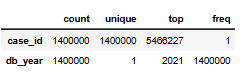

In [24]:
years = '''
    SELECT
        db_year,
        COUNT(*)
    FROM
        case_ids 
    GROUP BY db_year   
''' 
years = pd.read_sql_query(years, con = engine) 
years

,db_year,count
0,2021,1400000


In [25]:
del df_case
del years

### Таблица `vechicles`

In [26]:
vechicles = '''
    SELECT
        *
    FROM
        Vehicles
    LIMIT 20    
''' 


In [27]:
df_vechicles = pd.read_sql_query(vechicles, con = engine) 

In [28]:
df_vechicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


* Есть пропуски в трансмиссии и возрасте авто
* Также наблюдаются выбросы в кол-ве участников дтп и возрасте авто

In [29]:
del df_vechicles

### Таблица `collisions `

In [30]:
collisions  = '''
    SELECT
        *
    FROM
        collisions
    LIMIT 20
''' 


In [31]:
df_collisions  = pd.read_sql_query(collisions, con = engine) 

In [32]:
df_collisions

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00
5,4083097,0109,alameda,0.0,None,1,clear,ramp,small damage,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-18,02:18:00
6,4083092,1942,los angeles,1320.0,south,0,clear,highway,scratch,2,vehicle code violation,unsafe lane change,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,10:30:00
7,4083096,1942,los angeles,200.0,south,0,clear,highway,scratch,3,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,08:55:00
8,4083100,1942,los angeles,2112.0,north,0,cloudy,highway,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,normal,daylight,none,2009-01-21,16:20:00
9,4083103,4313,santa clara,0.0,None,1,cloudy,None,scratch,2,vehicle code violation,None,broadside,other motor vehicle,wet,normal,dusk or dawn,functioning,2009-01-02,15:55:00


In [33]:
del df_collisions

### Таблица `Parties `

In [34]:
parties  = '''
    SELECT
        *
    FROM
        Parties
    LIMIT 20    
''' 


In [35]:
df_parties  = pd.read_sql_query(parties, con = engine) 

In [36]:
df_parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


In [37]:
del df_parties

Первичное знакомство с данными завершено, есть только замечание к case_ids, но требуемые поля содержатся в других таблицах

### Проверка связи между таблицами

In [38]:
test_1 = '''
    SELECT
        COUNT(*) 
    FROM
        collisions c
    JOIN
        Parties p ON c.case_id = p.case_id;
'''

In [39]:
test_1_data = pd.read_sql_query(test_1, con = engine)

In [40]:
test_1_data

,count
0,2752408


In [41]:
test_2 = '''
    SELECT
        COUNT(*) 
    FROM
        Parties p
    JOIN
        vehicles v ON p.case_id = v.case_id AND p.party_number = v.party_number;
'''

In [42]:
test_2_data = pd.read_sql_query(test_2, con = engine)

In [43]:
test_2_data

,count
0,1021234


Оба запроса дали значения > 0 значит связь существует

##  Проведите статистический анализ факторов ДТП

### Аварии по месяцам

In [44]:
month_breaks  = '''
    WITH yearly_month_counts AS (
    SELECT
        EXTRACT(YEAR FROM collision_date) AS year,
        EXTRACT(MONTH FROM collision_date) AS month,
        COUNT(*) AS accident_count
    FROM
        collisions
    GROUP BY
        year, month
    ),
    complete_years AS (
        SELECT
            year
        FROM
            yearly_month_counts
        GROUP BY
            year
        HAVING
            COUNT(DISTINCT month) = 12  -- Берем только годы с полными данными за все месяцы
    )
    SELECT
        month,
        AVG(accident_count) AS avg_accidents,
        SUM(accident_count) AS total_accidents
    FROM
        yearly_month_counts
    WHERE
        year IN (SELECT year FROM complete_years)
    GROUP BY
        month
    ORDER BY
        month;    
''' 


In [45]:
month_breaks_data = pd.read_sql_query(month_breaks,con=engine)

In [46]:
month_breaks_data

,month,avg_accidents,total_accidents
0,1.0,32975.00,131900.0
1,2.0,32187.50,128750.0
2,3.0,34883.50,139534.0
3,4.0,32543.75,130175.0
4,5.0,32579.00,130316.0
5,6.0,25648.25,102593.0
6,7.0,25556.25,102225.0
7,8.0,26022.25,104089.0
8,9.0,26289.75,105159.0
9,10.0,28059.25,112237.0


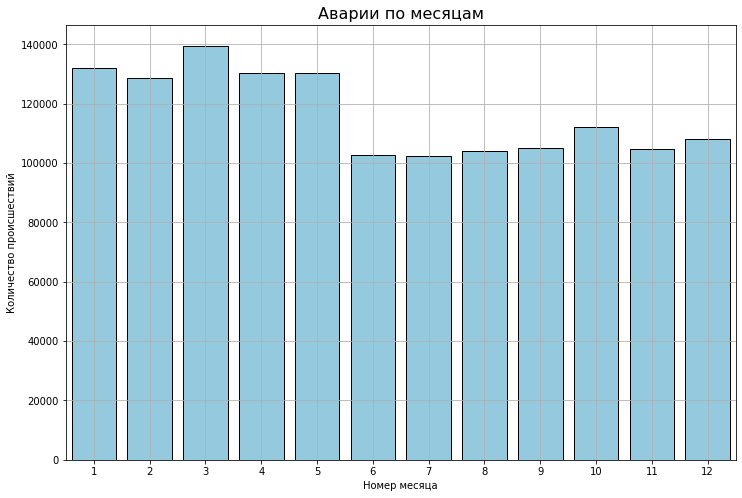

In [47]:
bar_plot_sql(
    month_breaks_data['month'].astype(int),
    month_breaks_data['total_accidents'],
    'Аварии по месяцам',
    'Номер месяца',
    'Количество происшествий'       
)

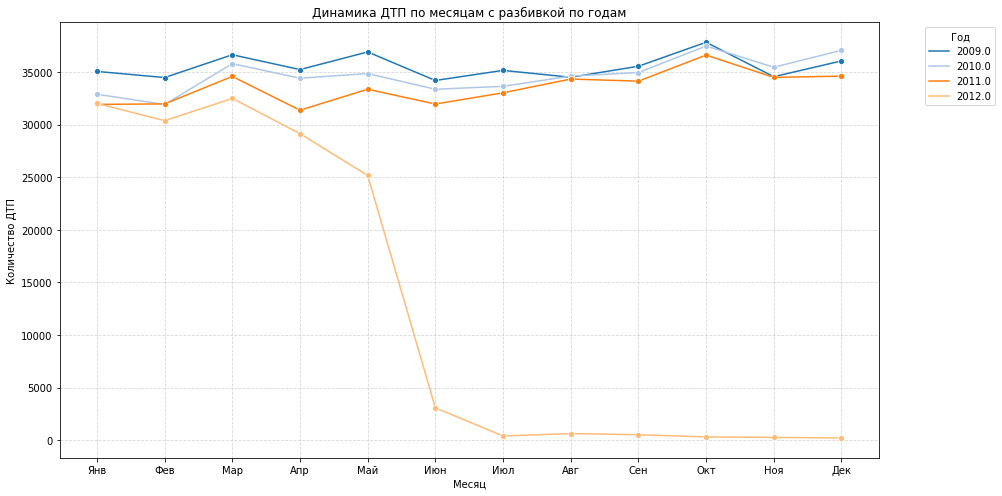

In [48]:
year_month_data = pd.read_sql_query('''
    SELECT
        EXTRACT(YEAR FROM collision_date) AS year,
        EXTRACT(MONTH FROM collision_date) AS month,
        COUNT(*) AS accident_count
    FROM
        collisions
    WHERE
        EXTRACT(YEAR FROM collision_date) IN (
            SELECT EXTRACT(YEAR FROM collision_date) 
            FROM collisions 
            GROUP BY EXTRACT(YEAR FROM collision_date) 
            HAVING COUNT(DISTINCT EXTRACT(MONTH FROM collision_date)) = 12
        )
    GROUP BY
        year, month
    ORDER BY
        year, month
''', engine)

plt.figure(figsize=(14, 7))
sns.lineplot(x='month', y='accident_count', hue='year', 
             data=year_month_data, marker='o', palette='tab20')
plt.title('Динамика ДТП по месяцам с разбивкой по годам')
plt.xlabel('Месяц')
plt.ylabel('Количество ДТП')
plt.xticks(range(1, 13), ['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                         'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'])
plt.grid(linestyle='--', alpha=0.5)
plt.legend(title='Год', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [49]:
del month_breaks_data
del year_month_data

Зимой и весной наблюдается наибольшее кол-во аварий (>120к)

Согласно задание необходимо выполнить следющие задачи:   
2.1. Создайте не менее шести задач для коллег. Опирайтесь на примеры и таблицы.      
2.2. Пропишите порядок решения для двух задач из списка. Реализуйте его. Обязательное условие — решение этих задач должно включать связь не менее 2-х таблиц.

1. Распределение ДТП по типам кузова в снегопад


2. Влияние использования телефона на тип ДТП


3. Аварии с пешеходами в темное время суток когда водитель был не пьян


4. Топ самых опасных районов для водителей (или районов где люди находятся за рулем в состоянии оаьянения) в состоянии опьянения


5. Связь погоды и тяжести ДТП с учетом трезвости водителя


6. Сравнить частоту ДТП для автомобилей с автоматической и механической КПП и сцеплением с дорогой

### Аварии по типу кузова в снегопад

In [50]:
vechicle_snow  = '''
    
    SELECT
        DISTINCT(v.vehicle_type),
        COUNT(*) OVER(PARTITION BY v.vehicle_type)as snow_boom
    FROM
        collisions c 
    JOIN
        Vehicles v ON c.case_id=v.case_id
    WHERE
        c.weather_1 = 'snowing'
    ORDER BY
        snow_boom
        
''' 


vechicle_snow_data = pd.read_sql_query(vechicle_snow,con=engine)

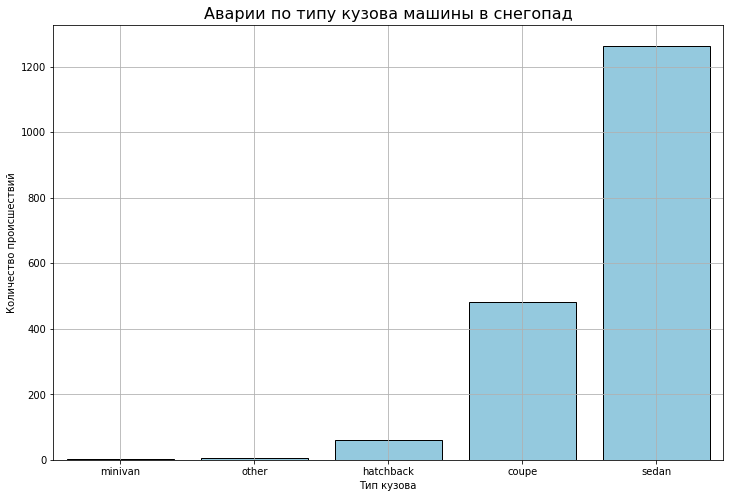

In [51]:
bar_plot_sql(
    vechicle_snow_data['vehicle_type'],
    vechicle_snow_data['snow_boom'],
    'Аварии по типу кузова машины в снегопад',
    'Тип кузова',
    'Количество происшествий'       
)

купе и седаны чаще всего оказываются в дтп в снежную погоду

In [52]:
 del vechicle_snow_data

### Аварии по причине алкогольного опьянения в районах

In [53]:
drunk_places  = '''
    
    SELECT
        c.county_location, 
        COUNT(*) as cnt_acc
    FROM
        collisions c 
    JOIN
        Parties p ON c.case_id=p.case_id
    WHERE
        p.party_sobriety IN ('had been drinking, under influence')
    GROUP BY
        c.county_location
    ORDER BY 
        cnt_acc DESC
    LIMIT 10    
        
''' 


drunk_places_data = pd.read_sql_query(drunk_places,con=engine)

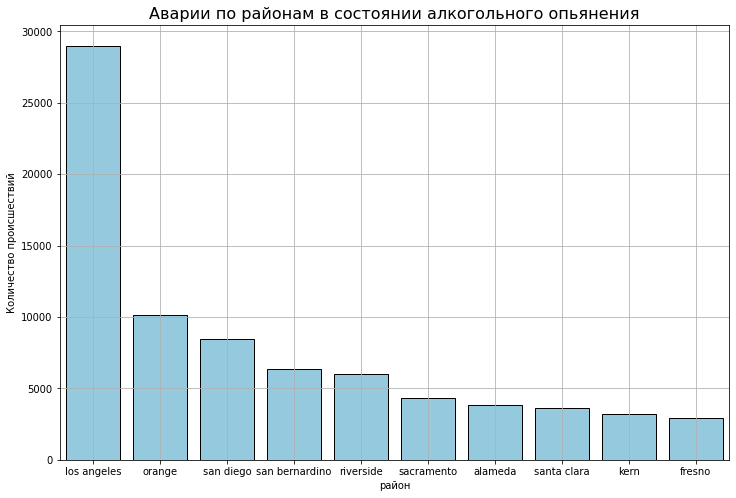

In [54]:
bar_plot_sql(
    drunk_places_data['county_location'],
    drunk_places_data['cnt_acc'],
    'Аварии по районам в состоянии алкогольного опьянения',
    'район',
    'Количество происшествий'       
)

Можно сделать вывод что в потерянных ангелах наиболее часто садятся за руль     
в состоянии алкогольного опьянения (**>25к**).     
Далее идут города апельсин, святой диего и святой бернардино    

В этих городах количесвто происшествий выше 5000

In [55]:
del drunk_places_data

### Тип аварии когда водитель говорил по телефону

In [56]:
call_to_death = '''SELECT 
            --p.CELLPHONE_IN_USE,
            c.TYPE_OF_COLLISION,
            COUNT(*) as accident_count
        FROM 
            collisions c
        JOIN 
            parties p ON c.CASE_ID = p.CASE_ID
        WHERE 
            p.PARTY_TYPE = 'car'
            AND p.CELLPHONE_IN_USE = 1
        GROUP BY 
            p.CELLPHONE_IN_USE, c.TYPE_OF_COLLISION
        ORDER BY accident_count DESC;
    '''

In [57]:
call_to_death_data = pd.read_sql_query(call_to_death,con=engine)

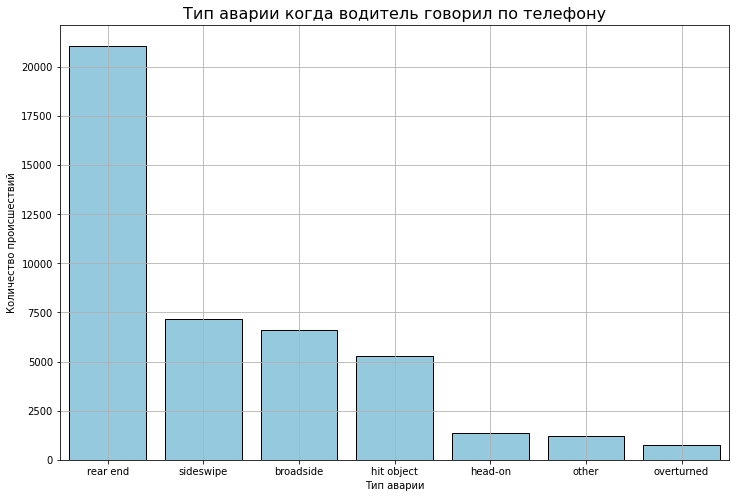

In [58]:
bar_plot_sql(
    call_to_death_data['type_of_collision'],
    call_to_death_data['accident_count'],
    'Тип аварии когда водитель говорил по телефону',
    'Тип аварии',
    'Количество происшествий'       
)

**Вывод**:
- Когда едешь задним ходом и говоришь по телефону, то вероятность столкновения высока (>20К).
- Также высока вероятность боковых ударов и врезаться в объект (>5К)
- Прямое столкновение или перевернуть машину <1.5K

In [59]:
del call_to_death_data

## Создайте модель для оценки водительского риска

1. Подготовим набор данных на основе первичного предположения заказчика:
- тип виновника — только машина (car).
- ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).
- данные только за 2012 год.
2. Проведем первичный отбор факторов, необходимых для модели.

 Отбор признаков для модели машинного обучения (таргет: at_fault)

---

1. Включаемые признаки
- Из таблицы collisions:

    - WEATHER_1 - влияет на видимость и управляемость

    - ROAD_SURFACE - состояние покрытия изменяет риск ДТП

    - LIGHTING - освещение связано с видимостью

    - INTERSECTION - перекрестки как зоны повышенного риска
  
    - COUNTY_LOCATION - вдруг есть города, где наблюдается наиболее частые ДТП


- Из таблицы parties:

    - PARTY_SOBRIETY - ключевой фактор виновности

    - **Можно было бы включить данный признак PARTY_DRUG_PHYSICAL - физическое состояние участника.     
      Но там около 80% пропущенных данных и нет возможности их восттановить. Поэтому его включать не будем**

    - CELLPHONE_IN_USE - отвлечение внимания водителя

    - PARTY_TYPE - тип участника (водитель/пешеход)


- Из таблицы vehicles:

    - VEHICLE_AGE - безопасность старых автомобилей

    - VEHICLE_TYPE - влияние типа кузова на управляемость

    - VEHICLE_TRANSMISSION - особенности управления (автомат/механика)


2. Исключаемые признаки

    - PARTY_NUMBER - порядковый номер участника
    
    - PRIMARY_COLL_FACTOR - основная причина аварии

    - COLLISION_DATE/TIME - сырые временные метки
    
    - TYPE_OF_COLLISION - характер столкновения указывает на вину

    - COUNTY_CITY_LOCATION - требует сложной обработки
    
    - PCF_VIOLATION_CATEGORY - категория нарушения ПДД

    - INSURANCE_PREMIUM - следствие, а не причина

    - DISTANCE - малоинформативен для определения вины

3. Новые признаки:

- Время суток (из COLLISION_TIME)

- День недели (из COLLISION_DATE)

- Сезонность (из COLLISION_DATE)


Вывод
Отобранные признаки учитывают ключевые факторы виновности, исключают избыточные данные и включают преобразованные информативные признаки, что оптимально для построения предсказательной модели.

---

In [60]:
df_sql = '''
    SELECT
        -- Признаки из таблицы collisions
        Distinct(c.case_id),
        p.AT_FAULT,
        c.WEATHER_1,
        c.ROAD_SURFACE,
        c.LIGHTING,
        c.COUNTY_LOCATION,
        c.INTERSECTION,
        --c.TYPE_OF_COLLISION,
        --c.PRIMARY_COLLISION_FACTOR,
        --c.PCF_VIOLATION_CATEGORY,

        -- Признаки из таблицы parties 
         
        p.PARTY_SOBRIETY,
        p.CELLPHONE_IN_USE,
        --p.PARTY_NUMBER,

        -- Признаки из таблицы vehicles
        v.VEHICLE_AGE,
        v.VEHICLE_TYPE,
        v.VEHICLE_TRANSMISSION,

        -- Извлечение временных признаков из даты/времени
        CASE 
            WHEN EXTRACT(HOUR FROM c.COLLISION_TIME) BETWEEN 6 AND 12 THEN 'morning'
            WHEN EXTRACT(HOUR FROM c.COLLISION_TIME) BETWEEN 13 AND 18 THEN 'day'
            WHEN EXTRACT(HOUR FROM c.COLLISION_TIME) BETWEEN 19 AND 23 THEN 'evening'
        ELSE 'night'
    END AS time_of_day,
        EXTRACT(DOW FROM c.COLLISION_DATE)::INT AS day_of_week,
        EXTRACT(QUARTER FROM c.COLLISION_DATE)::INT AS season

    FROM
        Parties p
    INNER JOIN
        collisions c ON p.case_id=c.case_id
    INNER JOIN
        Vehicles v ON p.case_id=v.case_id AND p.PARTY_NUMBER = v.PARTY_NUMBER   
    WHERE
        p.PARTY_TYPE = 'car'
        AND c.COLLISION_DAMAGE != 'scratch'
        AND EXTRACT(YEAR FROM c.collision_date) = 2012;
'''

df = pd.read_sql_query(df_sql, con=engine)

In [61]:
show_info(df)

Количество строк выборки составляет: 56124 


'Первые пять строк'

,case_id,at_fault,weather_1,road_surface,lighting,county_location,intersection,party_sobriety,cellphone_in_use,vehicle_age,vehicle_type,vehicle_transmission,time_of_day,day_of_week,season
0,5125160,0,cloudy,dry,daylight,san diego,1.0,had not been drinking,0.0,2.0,sedan,auto,morning,5,1
1,5173738,0,clear,dry,daylight,sacramento,1.0,had not been drinking,0.0,5.0,sedan,auto,morning,1,2
2,5269486,0,clear,dry,daylight,sacramento,1.0,had not been drinking,0.0,1.0,sedan,auto,day,2,4
3,5319820,0,clear,dry,dark with street lights,san bernardino,0.0,had not been drinking,0.0,4.0,sedan,auto,evening,3,3
4,5329109,0,clear,dry,daylight,sacramento,1.0,had not been drinking,0.0,6.0,coupe,auto,day,6,4


Общая информация о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56124 entries, 0 to 56123
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   case_id               56124 non-null  object 
 1   at_fault              56124 non-null  int64  
 2   weather_1             55956 non-null  object 
 3   road_surface          55778 non-null  object 
 4   lighting              55970 non-null  object 
 5   county_location       56124 non-null  object 
 6   intersection          55950 non-null  float64
 7   party_sobriety        55254 non-null  object 
 8   cellphone_in_use      51665 non-null  float64
 9   vehicle_age           54436 non-null  float64
 10  vehicle_type          56124 non-null  object 
 11  vehicle_transmission  55267 non-null  object 
 12  time_of_day           56124 non-null  object 
 13  day_of_week           56124 non-null  int64  
 14  season                56124 non-null  int64 

'Описание'

,count,mean,std,min,25%,50%,75%,max
at_fault,56124.0,0.505541,0.499974,0.0,0.0,1.0,1.0,1.0
intersection,55950.0,0.221662,0.415369,0.0,0.0,0.0,0.0,1.0
cellphone_in_use,51665.0,0.020323,0.141105,0.0,0.0,0.0,0.0,1.0
vehicle_age,54436.0,4.857668,3.235610,0.0,3.0,4.0,7.0,161.0
day_of_week,56124.0,3.155085,2.049588,0.0,1.0,3.0,5.0,6.0
season,56124.0,1.464062,0.602079,1.0,1.0,1.0,2.0,4.0


'===================================================================================================='

Количество явных дубликатов составляет 0


## Предобработка данных

### Типы данных

Категориальные признаки :

- Из таблицы collisions:

    - WEATHER_1  — погодные условия
    
    - ROAD_SURFACE — состояние дороги
     
    - LIGHTING — освещение
     
    - INTERSECTION  — наличие перекрестка
     
    - TYPE_OF_COLLISION  — тип столкновения
     
    - PRIMARY_COLL_FACTOR  — основной фактор ДТП
     
    - PCF_VIOLATION_CATEGORY  — категория нарушения ПДД
     
    - Из таблицы parties:
     
    - PARTY_SOBRIETY  — трезвость водителя
     
    - CELLPHONE_IN_USE  — использование телефона (бинарный)
     

- Из таблицы vehicles:

    - VEHICLE_TYPE — тип кузова
     
    - VEHICLE_TRANSMISSION  — тип КПП

- Производные временные признаки:

    - time_of_day  — время суток
     
    - day_of_week  — день недели (можно считать категориальным)
     
    - season  — сезон года (категориальный)

Количественные признаки :

Из таблицы vehicles:

- VEHICLE_AGE (целое число) — возраст автомобиля в годах

In [62]:
to_object = ['intersection', 'cellphone_in_use', 'day_of_week', 'season']

In [63]:
for col in to_object:
    df[col] = df[col].astype(object)

In [64]:
df.dtypes

case_id                  object
at_fault                  int64
weather_1                object
road_surface             object
lighting                 object
county_location          object
intersection             object
party_sobriety           object
cellphone_in_use         object
vehicle_age             float64
vehicle_type             object
vehicle_transmission     object
time_of_day              object
day_of_week              object
season                   object
dtype: object

### Пропуски в данных

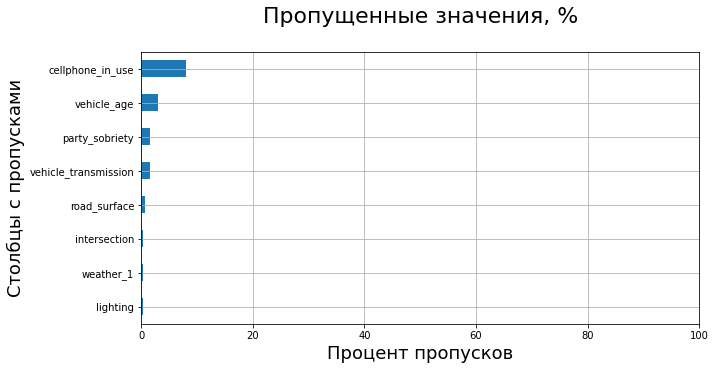

In [65]:
pass_value_barh(df)

Попробуем заполнить пропуски в данных:

#### cellphone_in_use

Так как нет косвенных признаков для восстановления даннх, то пропущенные значения заменим на unknown



In [66]:
df['cellphone_in_use'] = df['cellphone_in_use'].fillna('unknown') 

#### weather_1

Попробуем заполнить пропуски сгруппировав по состоянию дорожного покрытия. будет логично предположить, что в большинстве случаев если дорога мокрая или снежная, то идет дождь или снег

In [67]:
weather_mode_by_road = df.groupby('road_surface')['weather_1'].agg(pd.Series.mode)

In [68]:
weather_mode_by_road = weather_mode_by_road.apply(lambda x: x[0] if isinstance(x, pd.Series) else x)

In [69]:
def fill_weather(row):
    if pd.isna(row['weather_1']) and pd.notna(row['road_surface']):
        return weather_mode_by_road.get(row['road_surface'], None)
    return row['weather_1']

In [70]:
df['weather_1'] = df.apply(fill_weather, axis=1)

In [71]:
df['weather_1'].isna().sum()

62

в 62 оставшемся случае состояние дорожного покрытися неизвестно, поэтому остались пропуски.    
Попробуем заполнить по сезону года и локации местности

In [72]:
weather_mode_by_season_county = (
    df
    .groupby(['season', 'county_location'])['weather_1']
    .agg(lambda x: x.mode()[0] if not x.mode().empty else None)
    .to_dict()
)

In [73]:
def fill_weather_2(row):
    if pd.isna(row['weather_1']):
        key = (row['season'], row['county_location'])
        return weather_mode_by_season_county.get(key, None)
    return row['weather_1']

In [74]:
df['weather_1'] = df.apply(fill_weather_2, axis=1)

In [75]:
show_nan_col(df['weather_1'])

Количество Пропусков равно 0


####  road_surface
Воспользуемся такой же логикой, как и в предыдущем пункте

In [76]:
road_by_weather = df.groupby('weather_1')['road_surface'].agg(pd.Series.mode)

In [77]:
road_by_weather = road_by_weather.apply(lambda x: x[0] if isinstance(x, pd.Series) else x)

In [78]:
def fill_road(row):
    if pd.isna(row['road_surface']) and pd.notna(row['weather_1']):
        return road_by_weather.get(row['weather_1'], None)
    return row['road_surface']

In [79]:
df['road_surface'] = df.apply(fill_road, axis=1)

In [80]:
show_nan_col(df['road_surface'])

Количество Пропусков равно 0


####  lighting
Заполним пропуски по времени суток и городам

In [81]:
light_by_time_and_city = (
    df
    .groupby(['time_of_day', 'county_location'])['lighting']
    .agg(lambda x: x.mode()[0] if not x.mode().empty else None)
    .to_dict()
)

In [82]:
def fill_light(row):
    if pd.isna(row['lighting']):
        key = (row['time_of_day'], row['county_location'])
        return light_by_time_and_city.get(key, None)
    return row['lighting']

In [83]:
df['lighting'] = df.apply(fill_light, axis=1)

In [84]:
show_nan_col(df['lighting'])

Количество Пропусков равно 0


####  intersection
Заполним пропуски сгрупировав по городам

In [85]:
intersection_by_city = df.groupby('county_location')['intersection'].agg(pd.Series.mode)

In [86]:
intersection_by_city = intersection_by_city.apply(lambda x: x[0] if isinstance(x, pd.Series) else x)

In [87]:
def fill_intersection(row):
    if pd.isna(row['intersection']) and pd.notna(row['county_location']):
        return intersection_by_city.get(row['county_location'], None)
    return row['intersection']

In [88]:
df['intersection'] = df.apply(fill_intersection, axis=1)

In [89]:
show_nan_col(df['intersection'])

Количество Пропусков равно 0


####  party_sobriety
Заполним пропуски на имеющиеся значение not applicable (Не оценивался)

In [90]:
df['party_sobriety'] = df['party_sobriety'].fillna('not applicable') 

In [91]:
show_nan_col(df['party_sobriety'])

Количество Пропусков равно 0


####  vehicle_age
Заполним пропуски по медианным значениям типа автомобиля

In [92]:
median_age_by_type = df.groupby('vehicle_type')['vehicle_age'].median()

In [93]:
def fill_vehicle_age(row):
    if pd.isna(row['vehicle_age']):
        return median_age_by_type.get(row['vehicle_type'], df['vehicle_age'].median())
    return row['vehicle_age']

df['vehicle_age'] = df.apply(fill_vehicle_age, axis=1)

In [94]:
show_nan_col(df['vehicle_age'])

Количество Пропусков равно 0


####  vehicle_transmission
Заполним пропуски по моде типа автомобиля

In [95]:
transm_by_type = df.groupby('vehicle_type')['vehicle_transmission'].agg(pd.Series.mode)

In [96]:
transm_by_type = transm_by_type.apply(lambda x: x[0] if isinstance(x, pd.Series) else x)

In [97]:
def fill_transm(row):
    if pd.isna(row['vehicle_transmission']) and pd.notna(row['vehicle_type']):
        return transm_by_type.get(row['vehicle_type'], None)
    return row['vehicle_transmission']

In [98]:
df['vehicle_transmission'].value_counts()

manual    29262
auto      26005
Name: vehicle_transmission, dtype: int64

In [99]:
df['vehicle_transmission'] = df.apply(fill_transm, axis=1)

In [100]:
df['vehicle_transmission'] = df['vehicle_transmission'].apply(
    lambda x: x[0] if isinstance(x, (list, np.ndarray)) else x
)

In [101]:
show_nan_col(df['vehicle_transmission'])

Количество Пропусков равно 0


In [102]:
df.isna().sum()

case_id                 0
at_fault                0
weather_1               0
road_surface            0
lighting                0
county_location         0
intersection            0
party_sobriety          0
cellphone_in_use        0
vehicle_age             0
vehicle_type            0
vehicle_transmission    0
time_of_day             0
day_of_week             0
season                  0
dtype: int64

----

**Итог:**     
Пропуски полностью обработаны


****

### скрытые дубликаты

In [103]:
df = df.set_index('case_id')

In [104]:
category_hide_duplicates(df)

weather_1 :
['cloudy' 'clear' 'fog' 'other' 'raining' 'wind' 'snowing']
road_surface :
['dry' 'wet' 'snowy' 'slippery']
lighting :
['daylight' 'dark with street lights' 'dusk or dawn'
 'dark with no street lights' 'dark with street lights not functioning']
county_location :
['san diego' 'sacramento' 'san bernardino' 'santa clara' 'los angeles'
 'kern' 'riverside' 'san benito' 'san luis obispo' 'humboldt' 'el dorado'
 'san joaquin' 'placer' 'plumas' 'butte' 'nevada' 'mariposa' 'orange'
 'imperial' 'kings' 'yolo' 'tulare' 'sonoma' 'santa barbara' 'fresno'
 'stanislaus' 'ventura' 'shasta' 'santa cruz' 'mendocino' 'madera'
 'lassen' 'alameda' 'monterey' 'merced' 'yuba' 'contra costa' 'san mateo'
 'solano' 'tehama' 'san francisco' 'modoc' 'calaveras' 'amador' 'mono'
 'marin' 'tuolumne' 'sutter' 'napa' 'colusa' 'siskiyou' 'glenn' 'inyo'
 'lake' 'trinity' 'alpine' 'del norte' 'sierra']
party_sobriety :
['had not been drinking' 'impairment unknown'
 'had been drinking, under influence'
 'had b

1. Заменим пробелы в данных на _

2.  в Lightning есть похожие формулировки :
     - 'dark with street lights not functioning'
     - 'dark with no street lights'     
     Их можно объединить в одну категорию
     
3. В party sobriety всех выпивших отнесем к категории had been drinking.

4. В cellphone_in_use Заменим 1.0 на да, 0.0 на нет

In [105]:
df['lighting'] = (
    df['lighting']
    .str.replace('dark with street lights not functioning',
                 'dark with no street lights')
)

In [106]:
drink_mapping = {
    'had been drinking, under influence': 'had been drinking',
    'had been drinking, impairment unknown': 'had been drinking',
    'had been drinking, not under influence': 'had been drinking'
}
df['party_sobriety'] = df['party_sobriety'].replace(drink_mapping)

In [107]:
phone_mapping = {
    0.0: 'no',
    1.0: 'yes'
}
df['cellphone_in_use'] = df['cellphone_in_use'].replace(phone_mapping)
df['intersection'] = df['intersection'].replace(phone_mapping)

In [108]:
cat_col_names = ['weather_1', 'road_surface', 'lighting', 'county_location', 
    'type_of_collision', 'primary_collision_factor', 'pcf_violation_category',
    'party_sobriety', 'vehicle_type', 'vehicle_transmission', 'time_of_day']
for col in cat_col_names:
    if col in df.columns:
        df[col] = df[col].str.replace(' ', '_', regex=False).str.lower()

In [109]:
dow_mapping = {
    0: 'sunday',
    1: 'monday',
    2: 'tuesday',
    3: 'wednsday',
    4: 'saturday',
    5: 'friday',
    6: 'saturday'
}
season_mapping = {
    1: 'winter',
    2: 'spring',
    3: 'summer',
    4: 'fall'
}

df['day_of_week'] = df['day_of_week'].map(dow_mapping)
df['season'] = df['season'].map(season_mapping)


In [110]:
category_hide_duplicates(df)

weather_1 :
['cloudy' 'clear' 'fog' 'other' 'raining' 'wind' 'snowing']
road_surface :
['dry' 'wet' 'snowy' 'slippery']
lighting :
['daylight' 'dark_with_street_lights' 'dusk_or_dawn'
 'dark_with_no_street_lights']
county_location :
['san_diego' 'sacramento' 'san_bernardino' 'santa_clara' 'los_angeles'
 'kern' 'riverside' 'san_benito' 'san_luis_obispo' 'humboldt' 'el_dorado'
 'san_joaquin' 'placer' 'plumas' 'butte' 'nevada' 'mariposa' 'orange'
 'imperial' 'kings' 'yolo' 'tulare' 'sonoma' 'santa_barbara' 'fresno'
 'stanislaus' 'ventura' 'shasta' 'santa_cruz' 'mendocino' 'madera'
 'lassen' 'alameda' 'monterey' 'merced' 'yuba' 'contra_costa' 'san_mateo'
 'solano' 'tehama' 'san_francisco' 'modoc' 'calaveras' 'amador' 'mono'
 'marin' 'tuolumne' 'sutter' 'napa' 'colusa' 'siskiyou' 'glenn' 'inyo'
 'lake' 'trinity' 'alpine' 'del_norte' 'sierra']
intersection :
['yes' 'no']
party_sobriety :
['had_not_been_drinking' 'impairment_unknown' 'had_been_drinking'
 'not_applicable']
cellphone_in_use :
[

**********************
**Итог**:
1. Укрупнили категории
2. Заменили пробелы
3. Категоризировали данные
****

## Исследовательский анализ

### Количественные данные

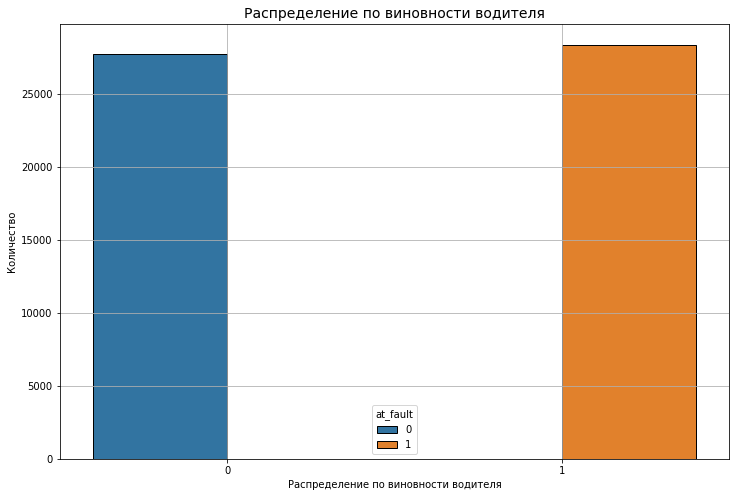

In [111]:
discrete_search_plot(df['at_fault'],'Распределение по виновности водителя')

Таргет достаточно сбалансирован, это очень хорошо для машинного обучения

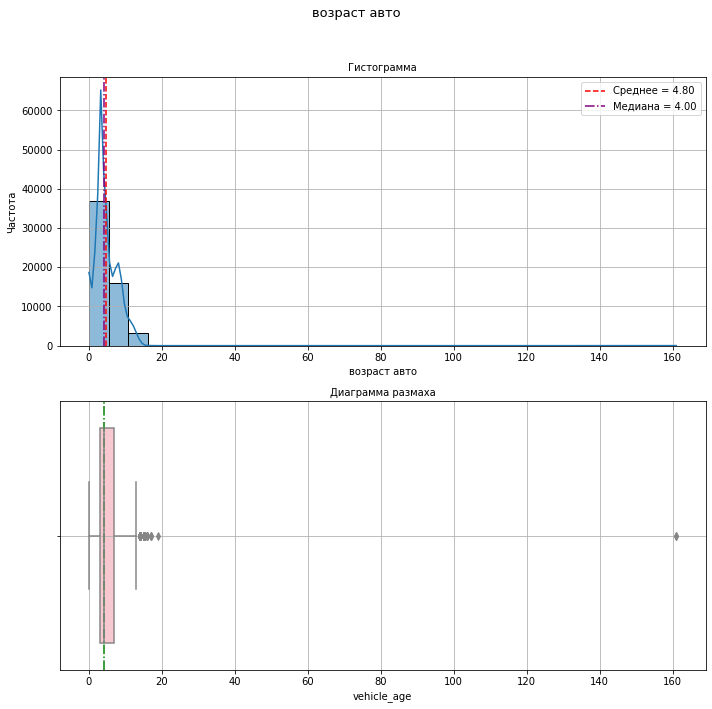

count    56124.000000
mean         4.802829
std          3.202078
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64


По тесту Шапиро-Уилка: Распределение отличается от нормального


In [112]:
search_plot(df['vehicle_age'],'возраст авто',30)

Наблюдается выброс в значении 161. Скорее всего здесь хотели написать 16 лет. заменим его


In [113]:
df.loc[df['vehicle_age'] == 161,'vehicle_age'] = 16

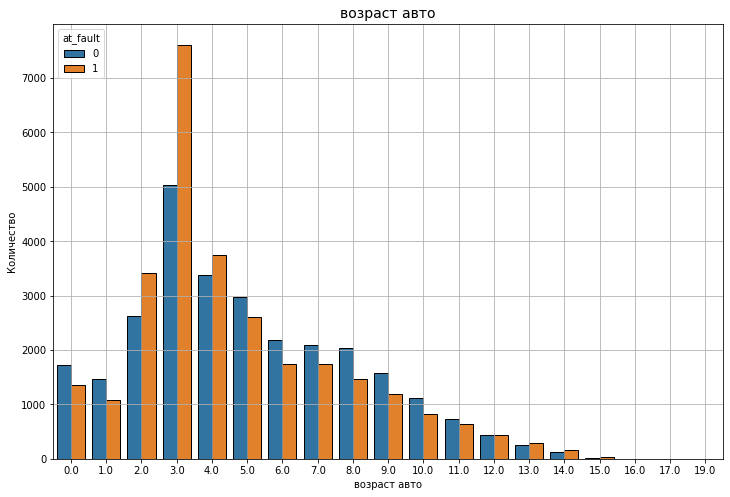

In [114]:
discrete_search_plot(df['vehicle_age'],'возраст авто')

In [115]:
df['vehicle_age'].value_counts()

3.0     12641
4.0      7138
2.0      6031
5.0      5584
6.0      3931
7.0      3834
8.0      3501
0.0      3081
9.0      2765
1.0      2541
10.0     1939
11.0     1377
12.0      879
13.0      551
14.0      282
15.0       37
16.0        8
17.0        3
19.0        1
Name: vehicle_age, dtype: int64

Так как количество машин с увеличением возраста уменьшается, попробую сделать этот признак категориальным.


In [116]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, float('inf')]
labels = ['0', '1_year', '2_years', '3_years', '4_years', '5_years', '6_years', '7_years', '8_years', '9_more']

df['vehicle_age'] = pd.cut(df['vehicle_age'], bins=bins, labels=labels, right=False).astype('object')

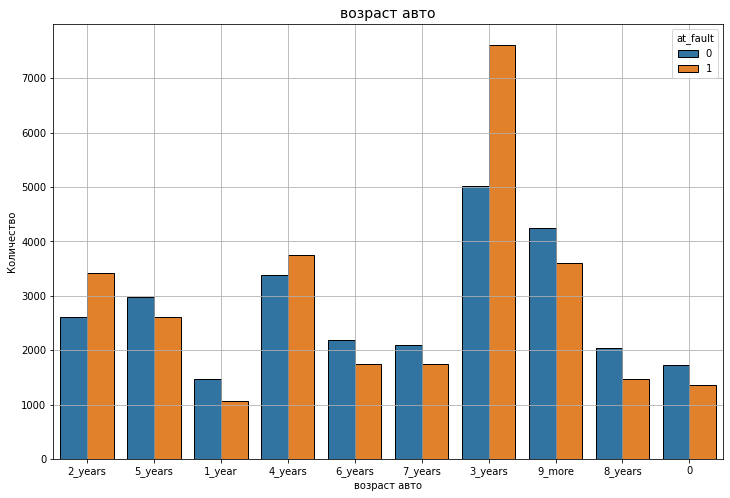

In [117]:
discrete_search_plot(df['vehicle_age'],'возраст авто')

Машины с возрастом в 2-4 года наиболее чаще попадают в дтп и являются виновными

<div class="alert alert-success">
<b>👍 Успех:</b> Все верно!
</div>

### Категориальные данные

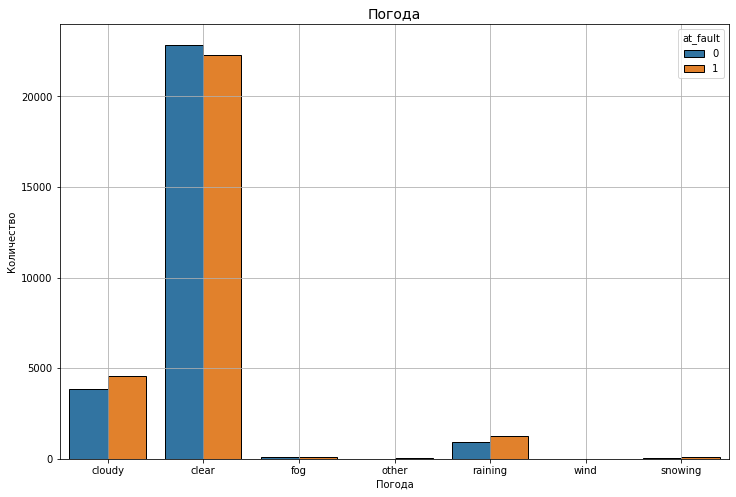

In [118]:
discrete_search_plot(df['weather_1'],'Погода')

In [119]:
df['weather_1'].value_counts()

clear      45149
cloudy      8416
raining     2174
fog          180
snowing      160
other         34
wind          11
Name: weather_1, dtype: int64

Есть дисбаланс по погоде      
Виноватыми оказывается водители чаще в дождливую и облачную погоду

----


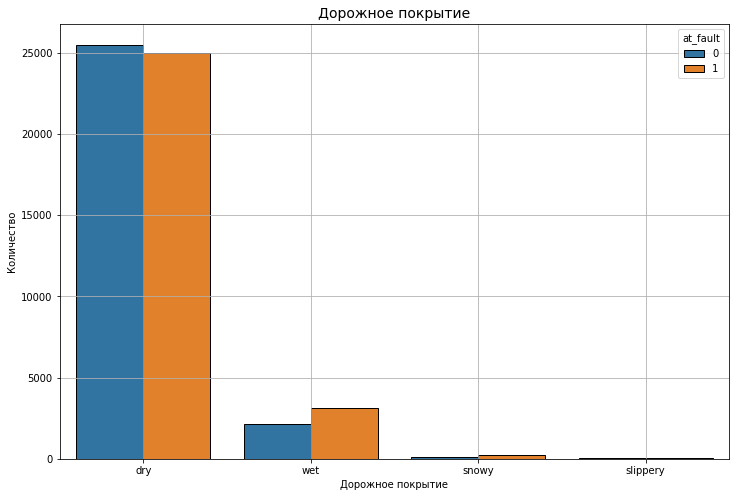

In [120]:
discrete_search_plot(df['road_surface'],'Дорожное покрытие')

Думаю, что погодные признаки не будут слишком полезные, так как в большинсте случаев погода была хорошая, а значит проблема в другом

----

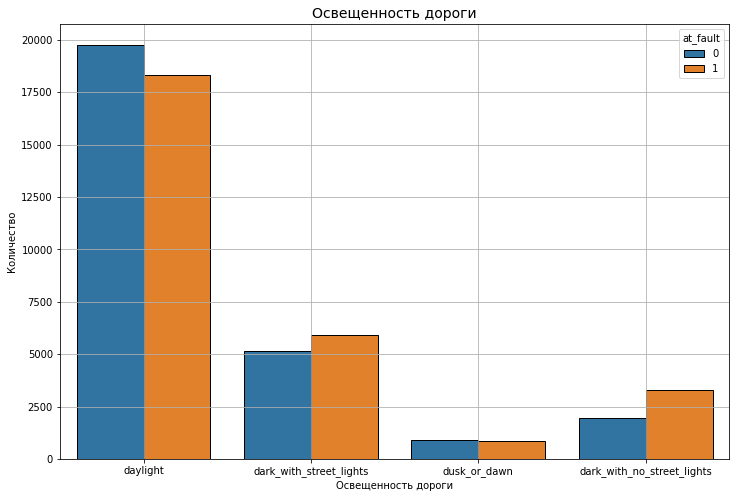

In [121]:
discrete_search_plot(df['lighting'],'Освещенность дороги')

В любую освещенность примерно одинаковое количество виновных и невиновных, за исключением темных участков

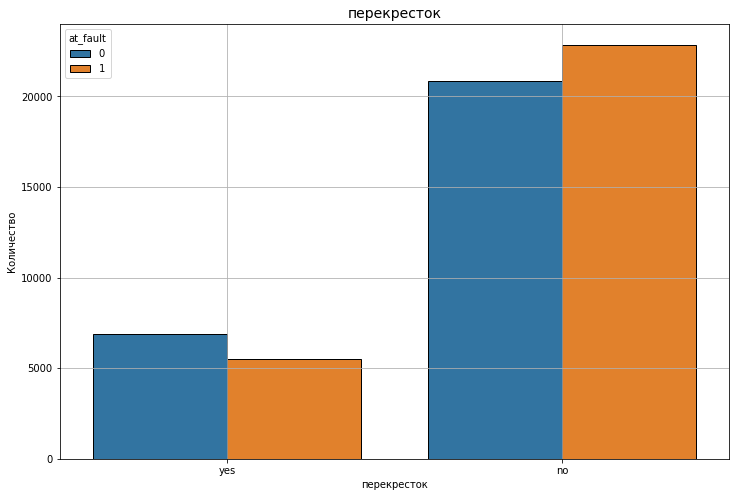

In [122]:
discrete_search_plot(df['intersection'],'перекресток')

На перекрестках чаще вина происходит не от водителя каршеринга.Также на перекретсках реже случаются дтп

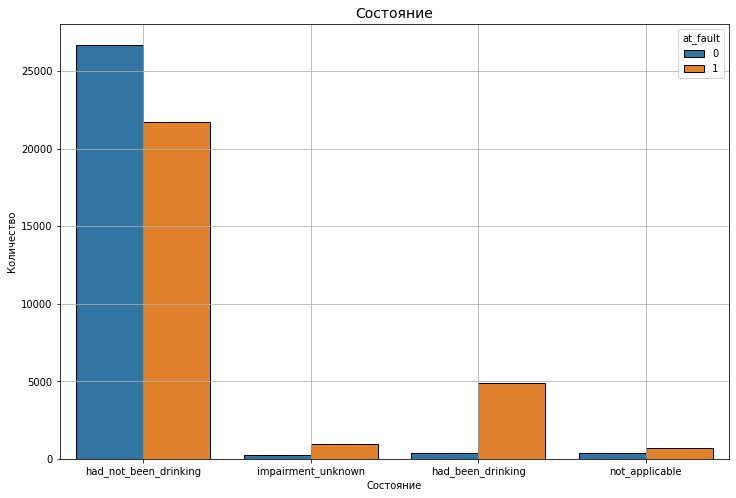

In [123]:
discrete_search_plot(df['party_sobriety'],'Состояние')

состояние алкогольного опьянения значительно увеличивает шанс на вину дтп

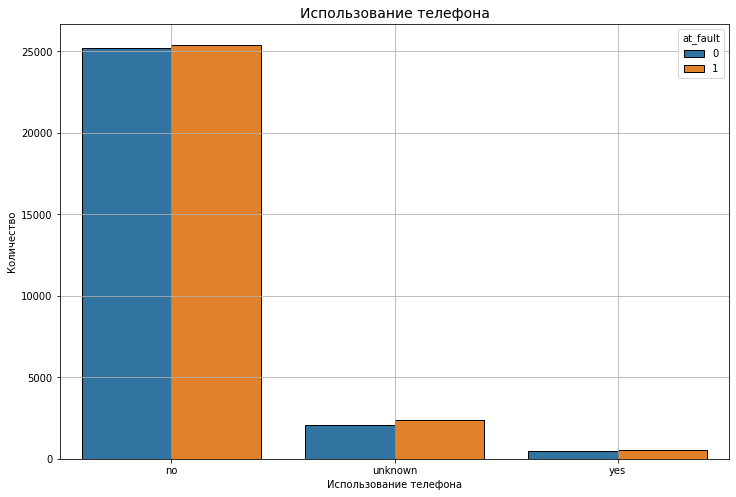

In [124]:
discrete_search_plot(df['cellphone_in_use'],'Использование телефона')

Практически нет водителей, которые говорят по телефону. Если говорят, то чаще будут виноватыми

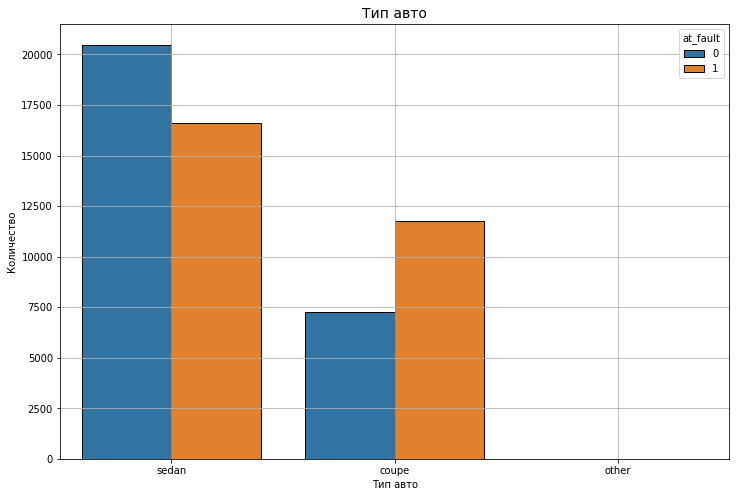

In [125]:
discrete_search_plot(df['vehicle_type'],'Тип авто')

Купе чаше бывает виноват в дтп, может дело в управляемости даных моделей..

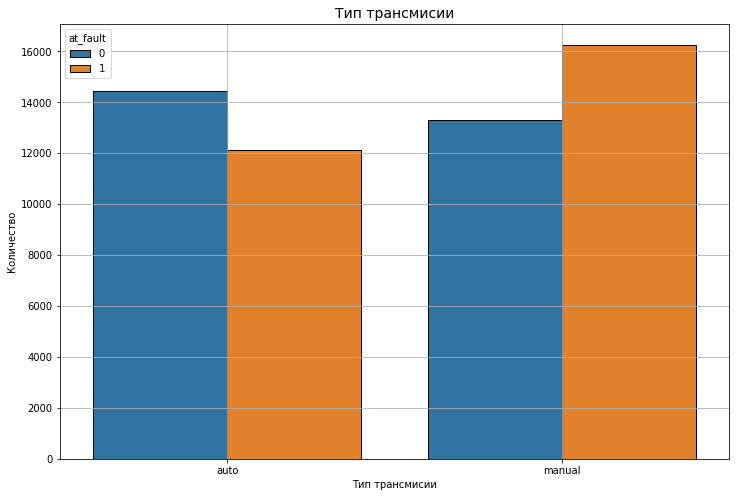

In [126]:
discrete_search_plot(df['vehicle_transmission'],'Тип трансмисии')

Ручная коробка передач чаще приводит к аварии и виновности в дтп

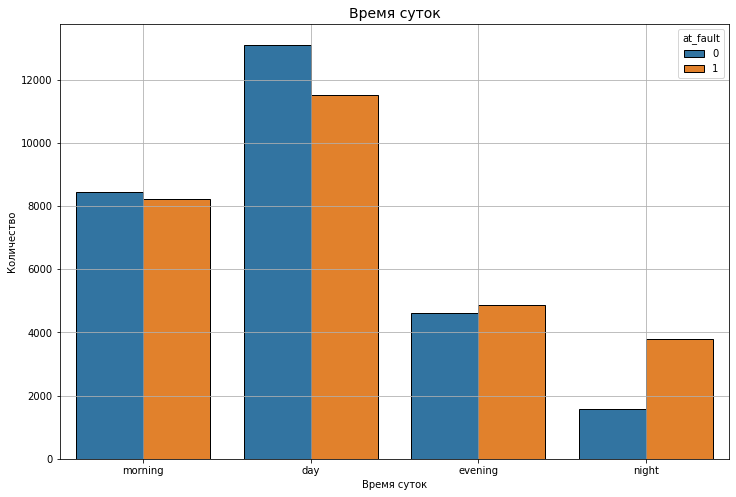

In [127]:
discrete_search_plot(df['time_of_day'],'Время суток')

Ночью чаще водитель бывает виноват в дтп. Большинство аварий бывают днем

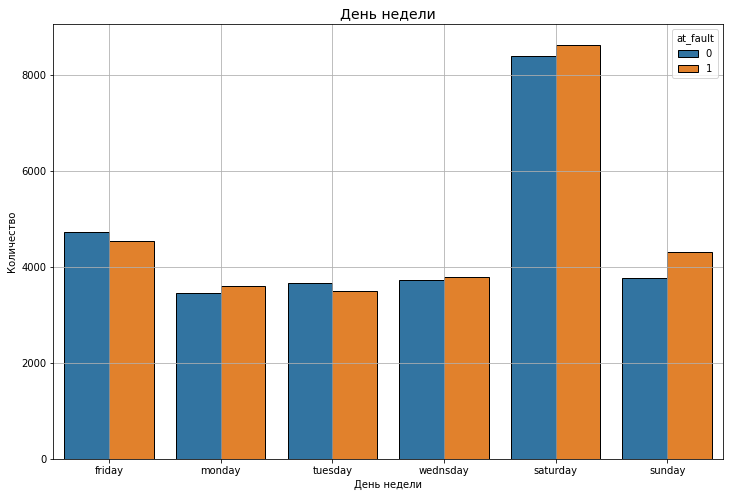

In [128]:
discrete_search_plot(df['day_of_week'],'День недели')

Суббота самый аварийный день и чаще всего водитель виноват в дтп

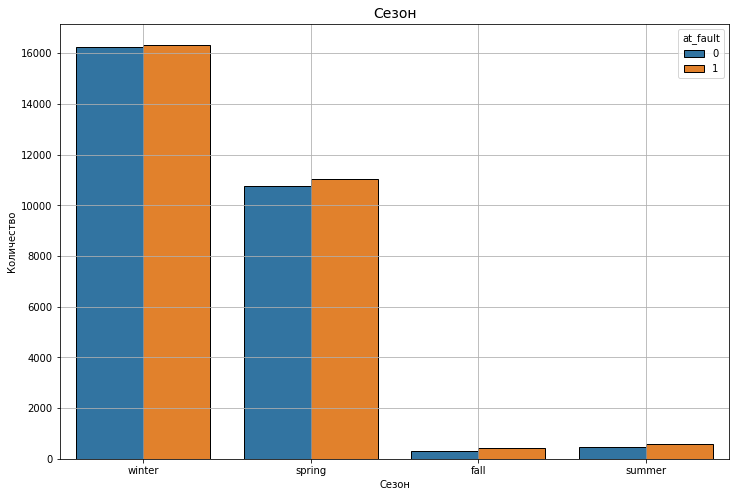

In [129]:
discrete_search_plot(df['season'],'Сезон')

Из запроса в п.4.1. мы уже отметили, что кол-во аварий снизилось после июня месяца

### Матрица корреляции


In [130]:
%%time
phik_matrix = (
    df
    .phik_matrix(interval_cols=df.select_dtypes(include='number')
    .columns.tolist())
)

CPU times: user 1.97 s, sys: 42.5 ms, total: 2.01 s
Wall time: 2.02 s


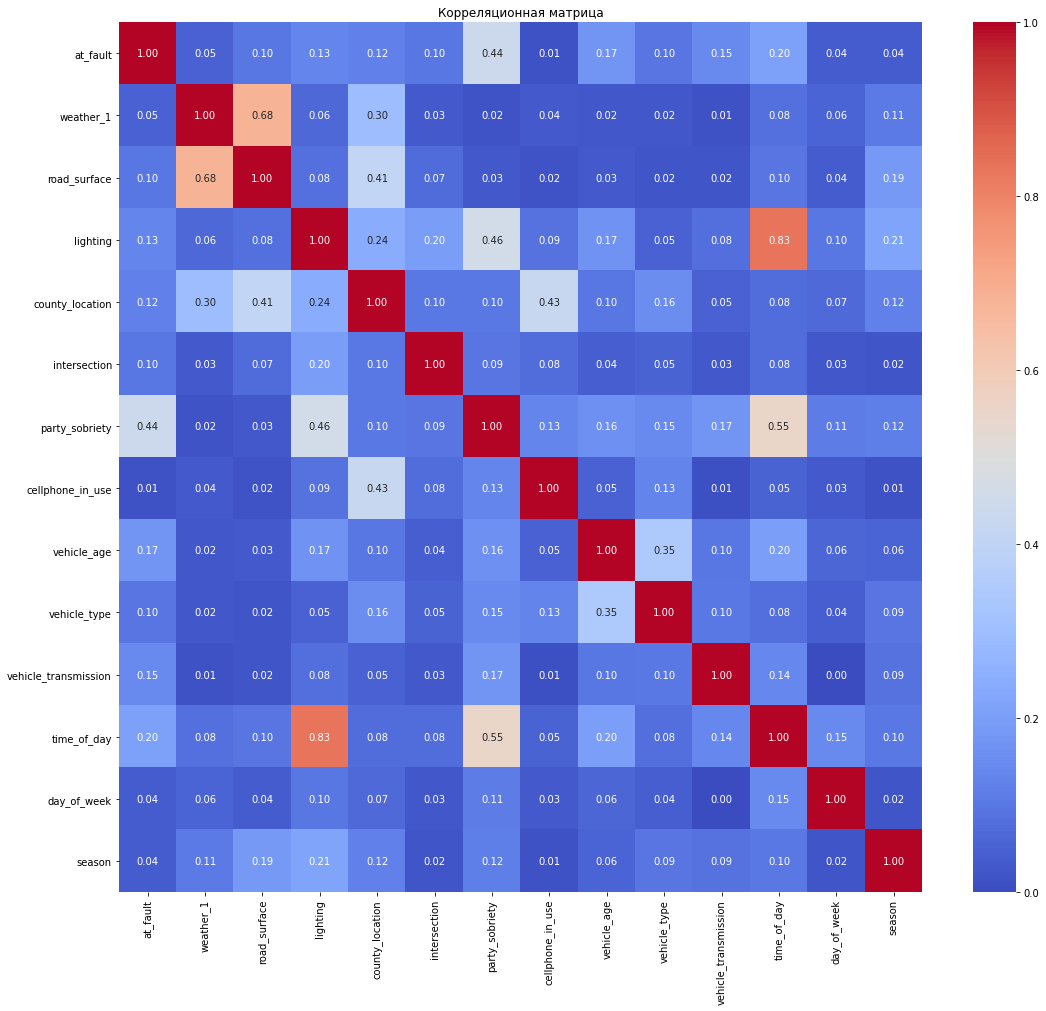

In [131]:
plt.figure(figsize=(18, 16))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

1. **Корреляция с целевым признаком "at_fault"**:


    - vehicle age 
    - party_sobriety 
    - time of day
    
    
2. **Слабо коррелирующие признаки**:

    - season --> можно удалить
    - cellphone_in_use
    - day of week
    
3. **Выводы**:

В целом данные не сильно коррелируют с целевым признаком и корреляция слабая

## Подготовка данных к обучению

In [132]:
df.columns


Index(['at_fault', 'weather_1', 'road_surface', 'lighting', 'county_location',
       'intersection', 'party_sobriety', 'cellphone_in_use', 'vehicle_age',
       'vehicle_type', 'vehicle_transmission', 'time_of_day', 'day_of_week',
       'season'],
      dtype='object')

In [133]:
df_train = df.drop(['season','cellphone_in_use','day_of_week'], axis = 1)

In [134]:
X_train, X_test, y_train, y_test, num_columns,category_features, kf = prepare_data(df_train,'at_fault')

In [135]:
print('размер тренировочной выборки(строк, столбцов):', X_train.shape)
print('размер тестовой выборки(строк, столбцов):', X_test.shape)

размер тренировочной выборки(строк, столбцов): (42093, 10)
размер тестовой выборки(строк, столбцов): (14031, 10)


In [136]:
print('размер тренировочного таргета:', y_train.shape)
print('размер тестового таргета:', y_test.shape)

размер тренировочного таргета: (42093,)
размер тестового таргета: (14031,)


### Пайплайн

In [137]:
ohe_pipe = Pipeline(
    [
        (
            'SimpleImputer_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe',
            OneHotEncoder(handle_unknown='ignore', drop='first',sparse_output=False)
        )
    ]
)
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, category_features),
        ('num', StandardScaler(), num_columns),
        ], remainder='passthrough'
)
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', LogisticRegression(random_state=RANDOM_STATE))
    ]
)

## Машинное обучение

**В качестве основной метрики будем использовать accuracy. Так как эта метрика позволит понять попадет человек в дтп или нет**

### Логистическая регрессия

In [138]:
def objective_logreg(trial):
    # Предлагаем разные модели
    model_name = trial.suggest_categorical('model', ['logreg']) # 'decision_tree', 'svc', 
    
    penalty = trial.suggest_categorical('models__penalty', ['l1', 'l2', 'elasticnet'])
    l1_ratio = trial.suggest_float('models__l1_ratio', 0, 1) if penalty == 'elasticnet' else None
    class_weight = trial.suggest_categorical('models__class_weight', [None, 'balanced', 'custom'])
    
    if class_weight == 'custom':
        # Ручная настройка весов для класса 1
        weight_class1 = trial.suggest_float('models__weight_class1', 0.1, 10.0)  # Подбираем вес для класса 1
        class_weight = {0: 1.0, 1: weight_class1}  # Вес класса 0 фиксирован, класса 1 — настраивается
        
        

    model = LogisticRegression(
        penalty=penalty,
        C=trial.suggest_float('models__C', 1e-3, 1e3, log=True),
        solver='saga',
        l1_ratio=l1_ratio,
        max_iter=1000,
        random_state=RANDOM_STATE,
        class_weight=class_weight  
    )
    
    pipe_final.set_params(models=model)
    score = cross_val_score(pipe_final, X_train, y_train, 
                          cv=5, scoring='accuracy').mean()
    return score

In [139]:
study = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_STATE),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10)
)

[I 2025-06-15 16:13:16,304] A new study created in memory with name: no-name-a51b2f8d-a8f1-4a90-b1f2-7b7e748e5ac6


In [140]:
study.optimize(objective_logreg, n_trials=15, timeout=1200, show_progress_bar=True)

  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-06-15 16:13:24,215] Trial 0 finished with value: 0.6365666042181174 and parameters: {'model': 'logreg', 'models__penalty': 'l2', 'models__class_weight': None, 'models__C': 0.002231010801867922}. Best is trial 0 with value: 0.6365666042181174.
[I 2025-06-15 16:13:33,805] Trial 1 finished with value: 0.638538405378031 and parameters: {'model': 'logreg', 'models__penalty': 'l1', 'models__class_weight': 'balanced', 'models__C': 0.018794668241638456}. Best is trial 1 with value: 0.638538405378031.
[I 2025-06-15 16:13:42,807] Trial 2 finished with value: 0.6091987116561491 and parameters: {'model': 'logreg', 'models__penalty': 'elasticnet', 'models__l1_ratio': 0.5247564316322378, 'models__class_weight': 'custom', 'models__weight_class1': 1.4809892204552142, 'models__C': 0.05660670699258887}. Best is trial 1 with value: 0.638538405378031.
[I 2025-06-15 16:14:06,005] Trial 3 finished with value: 0.6391797524583419 and parameters: {'model': 'logreg', 'models__penalty': 'elasticnet', 'mo

In [141]:
def best_model_study(best_params):
    best_model = LogisticRegression(
        penalty=best_params['models__penalty'],
        C=best_params['models__C'],
        solver='saga',
        l1_ratio=best_params.get('models__l1_ratio', None),  # для elasticnet
        max_iter=1000,
        random_state=RANDOM_STATE
    )
    return best_model

In [142]:
best_params = study.best_params

In [143]:
best_model_lr = best_model_study(best_params)

In [144]:
pipe_final.set_params(models=best_model_lr)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['weather_1', 'road_surface',
                                                   'lighting',
                                                   'county_location',
                                                   'intersection',
                                                   'party_sobriety',
                                                   'vehicle_age',
                                                   'vehicle_type',
                                                   'vehicle_transmission',
                                                   'time_of_day']),
                                                 ('num', StandardScaler(),
                                                  [])])),
                ('models',
                 LogisticRegression(C=0.07417652034871831,
                                    l1_ratio=0.034388521115218396,
                                    max_iter=1000, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

In [145]:
pipe_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('SimpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['weather_1', 'road_surface',
                                                   'lighting',
                                                   'county_location',
                                                   'intersection',
                                                   'party_sobriety',
                                                   'vehicle_age',
                                                   'vehicle_type',
                                                   'vehicle_transmission',
                                                   'time_of_day']),
                                                 ('num', StandardScaler(),
                                                  [])])),
                ('models',
                 LogisticRegression(C=0.07417652034871831,
                                    l1_ratio=0.034388521115218396,
                                    max_iter=1000, penalty='elasticnet',
                                    random_state=42, solver='saga'))])

In [146]:
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

In [147]:
# Запускаем кросс-валидацию (cv=5 или другое число фолдов)
cv_results = cross_validate(
    pipe_final,
    X_train, y_train,
    cv=5,
    scoring=scoring,
    return_train_score=False  # Можно включить, если нужны train-метрики
)

In [148]:
# Выводим средние значения метрик по фолдам
accuracy_lr = cv_results['test_accuracy'].mean()
precision_lr = cv_results['test_precision'].mean()
recall_lr = cv_results['test_recall'].mean()
f1_lr = cv_results['test_f1'].mean()
roc_lr = cv_results['test_roc_auc'].mean()

print(f"CV Accuracy: {accuracy_lr:.4f}")
print(f"CV Precision: {precision_lr:.4f}")
print(f"CV Recall: {recall_lr:.4f}")
print(f"CV F1-score: {f1_lr:.4f}")
print(f"CV ROC-AUC: {roc_lr:.4f}")

CV Accuracy: 0.6405
CV Precision: 0.6743
CV Recall: 0.5587
CV F1-score: 0.6111
CV ROC-AUC: 0.6951


### RandomForest

In [149]:
pipe_rf = Pipeline([
    ('preprocessor', data_preprocessor),
    ('rf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
])

In [150]:
param_grid_forest = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 10, 20, 30],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', None]
}

In [151]:
random_search = RandomizedSearchCV(
    estimator=pipe_rf,
    param_distributions=param_grid_forest,
    n_iter=30,  
    cv=kf,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    refit='accuracy',
    n_jobs=-1,   
    random_state=RANDOM_STATE,
    verbose=1
)

In [152]:
%%time
random_search.fit(X_train, y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
CPU times: user 8min 13s, sys: 3.05 s, total: 8min 16s
Wall time: 8min 17s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('SimpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['weat...
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=42))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'rf__max_depth': [None, 10, 20, 30],
                                        'rf__max_features': ['sqrt', 'log2',
                                                             None],
                                        'rf__min_samples_leaf': [1, 2, 4],
                                        'rf__min_samples_split': [2, 5, 10],
                                        'rf__n_estimators': [100, 200, 300]},
                   random_state=42, refit='accuracy',
                   scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                   verbose=1)

In [153]:
cv_results = random_search.cv_results_
accuracy_rf = cv_results['mean_test_accuracy'][random_search.best_index_]
precision_rf = cv_results['mean_test_precision'][random_search.best_index_]
recall_rf = cv_results['mean_test_recall'][random_search.best_index_]
f1_rf = cv_results['mean_test_f1'][random_search.best_index_]
roc_rf = cv_results['mean_test_roc_auc'][random_search.best_index_]

In [154]:
print(f"CV Accuracy: {accuracy_rf:.4f}")
print(f"CV Precision: {precision_rf:.4f}")
print(f"CV Recall: {recall_rf:.4f}")
print(f"CV F1-score: {f1_rf:.4f}")
print(f"CV ROC-AUC: {roc_rf:.4f}")

CV Accuracy: 0.6379
CV Precision: 0.6851
CV Recall: 0.5262
CV F1-score: 0.5950
CV ROC-AUC: 0.6917


### Catboost

In [155]:
category_features

['weather_1',
 'road_surface',
 'lighting',
 'county_location',
 'intersection',
 'party_sobriety',
 'vehicle_age',
 'vehicle_type',
 'vehicle_transmission',
 'time_of_day']

In [156]:
data_preprocessor_2 = ColumnTransformer(
    [
        ('cat', 'passthrough', category_features),
        ('num', StandardScaler(), num_columns),
        ], remainder='passthrough'
)
pipe_cb = Pipeline(
    [
        ('preprocessor', data_preprocessor_2),
        ('cb', CatBoostClassifier(
                            random_state=RANDOM_STATE,
                            silent=True,
                            cat_features=list(range(len(num_columns), 
                             len(num_columns) + len(category_features))
                            )
        )
        )
    ]
)

In [157]:
param_grid_cb = {
    'cb__iterations': [100, 200, 300],
    'cb__depth': [4, 6, 8],
    'cb__learning_rate': [0.01, 0.05, 0.1],
    'cb__l2_leaf_reg': [1, 3, 5]
}

In [158]:
random_search_cb = RandomizedSearchCV(
    estimator=pipe_cb,
    param_distributions=param_grid_cb,
    scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
    refit='accuracy',
    cv=kf,
    n_iter=30,
    n_jobs=-1,
    random_state=RANDOM_STATE,
    verbose=1
)

In [159]:
%%time
random_search_cb.fit(X_train, y_train)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
CPU times: user 5min 25s, sys: 4.35 s, total: 5min 29s
Wall time: 6min 11s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=2, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               'passthrough',
                                                                               ['weather_1',
                                                                                'road_surface',
                                                                                'lighting',
                                                                                'county_location',
                                                                                'intersection',
                                                                                'party_sobriety',
                                                                                'vehicle_age',
                                                                                'vehicle_type',
                                                                                'vehicle_transmission',
                                                                                'time_of_da...
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               [])])),
                                             ('cb',
                                              <catboost.core.CatBoostClassifier object at 0x7fbc11d607c0>)]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'cb__depth': [4, 6, 8],
                                        'cb__iterations': [100, 200, 300],
                                        'cb__l2_leaf_reg': [1, 3, 5],
                                        'cb__learning_rate': [0.01, 0.05, 0.1]},
                   random_state=42, refit='accuracy',
                   scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                   verbose=1)

In [160]:
cv_results_cat = random_search_cb.cv_results_
print(f"Best Recall: {cv_results['mean_test_recall'][random_search_cb.best_index_]:.4f}")
print(f"Best ROC-AUC: {cv_results['mean_test_roc_auc'][random_search_cb.best_index_]:.4f}")


Best Recall: 0.5256
Best ROC-AUC: 0.6913


In [161]:
cv_results_cat = random_search_cb.cv_results_
accuracy_cat = cv_results_cat['mean_test_accuracy'][random_search_cb.best_index_]
precision_cat = cv_results_cat['mean_test_precision'][random_search_cb.best_index_]
recall_cat = cv_results_cat['mean_test_recall'][random_search_cb.best_index_]
f1_cat = cv_results_cat['mean_test_f1'][random_search_cb.best_index_]
roc_cat = cv_results_cat['mean_test_roc_auc'][random_search_cb.best_index_]

In [162]:
print(f"Best CatBoost params: {random_search_cb.best_params_}")
print(f"CV Accuracy: {accuracy_cat:.4f}")
print(f"CV Precision: {precision_cat:.4f}")
print(f"CV Recall: {recall_cat:.4f}")
print(f"CV F1-score: {f1_cat:.4f}")
print(f"CV ROC-AUC: {roc_cat:.4f}")

Best CatBoost params: {'cb__learning_rate': 0.05, 'cb__l2_leaf_reg': 3, 'cb__iterations': 300, 'cb__depth': 4}
CV Accuracy: 0.6417
CV Precision: 0.6930
CV Recall: 0.5230
CV F1-score: 0.5961
CV ROC-AUC: 0.6984


### Сравнение моделей

In [163]:
accuracy_lst= [accuracy_lr, accuracy_rf, accuracy_cat]
precision_lst= [precision_lr, precision_rf, precision_cat]
recall_lst= [recall_lr, recall_rf, recall_cat]
f1_lst= [f1_lr, f1_rf, f1_cat]
roc_lst= [roc_lr, roc_rf, roc_cat]


In [164]:
data = {
    "Model": ["logistic_regression", "random_forest", "CatBoost"],
    "Accuracy": accuracy_lst,
    "Precision": precision_lst,
    "Recall": recall_lst,
    "F1-score": f1_lst,
    "ROC-AUC": roc_lst,
}

metrics_df = pd.DataFrame(data)

In [167]:
metrics_df.sort_values(by='Accuracy', ascending=False)

,Model,Accuracy,Precision,Recall,F1-score,ROC-AUC
2,CatBoost,0.641698,0.692967,0.523026,0.596097,0.698405
0,logistic_regression,0.640463,0.674267,0.558741,0.611073,0.695086
1,random_forest,0.637944,0.685122,0.526175,0.594955,0.691738


**Итог по обученным моделям**:
1) CatBoost:   

* Наивысшие Accuracy (0.641698)      
* Лучший ROC-AUC (0.698405)   

2) Logistic Regression:     

* Accuracy чуть ниже, чем у CatBoost     
* Второй результат по ROC-AUC )     
* Лучший f1-score (0.685)     

3) Random Forest:    

* Средние показатели по всем метрикам    
    
    
**Вывод**: CatBoost показал наиболее сбалансированные результаты для текущей задачи предсказания ДТП, особенно с учетом важности     

### Финальное обучение

In [168]:
final_model = random_search_cb.best_estimator_

In [169]:
y_pred_final = final_model.predict(X_test)
y_proba_final = final_model.predict_proba(X_test)[:, 1]

In [170]:
evaluate_model(y_pred_final,y_proba_final);

Основные метрики на Тестовых данных
Accuracy:  0.6416
Precision: 0.6936
Recall:    0.5212
F1-score:  0.5952
ROC-AUC:   0.6985


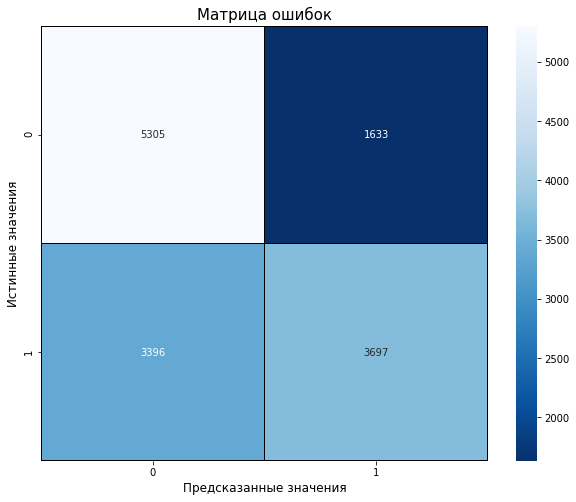

In [171]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r',linecolor='black',linewidths=0.5)
plt.xlabel('Предсказанные значения', fontsize=12)
plt.ylabel('Истинные значения', fontsize=12)
plt.title('Матрица ошибок', fontsize=15);

Итог:    
Дисбаланс ошибок смещение в сторону класса 0    
Модель лучше предсказывает невиновных, чем виновных.    
Попробуем настроить порог    

In [172]:
def thresholds_best(y_pred,y_proba, score):
    # Поиск оптимального порога
    thresholds = np.arange(0.01, 1.0, 0.001)  # Перебираем пороги от 0.1 до 0.99
    best_threshold = 0.5
    best_f1 = 0

    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)  # Применяем порог
        f1 = score(y_test, y_pred)  
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print(f"Лучший порог: {best_threshold}")
    print(f"Лучший score: {best_f1}")
    return best_threshold

In [176]:
best_threshold = thresholds_best(y_pred_final,y_proba_final, accuracy_score)

Лучший порог: 0.4869999999999996
Лучший score: 0.6439312949896657


In [177]:
res = (y_proba_final >= best_threshold).astype(int)

In [178]:
evaluate_model(res,y_proba_final);

Основные метрики на Тестовых данных
Accuracy:  0.6439
Precision: 0.6777
Recall:    0.5637
F1-score:  0.6155
ROC-AUC:   0.6985


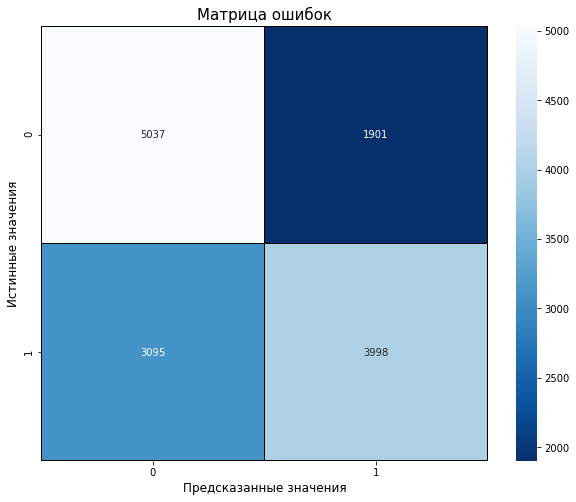

In [179]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, res)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r',linecolor='black',linewidths=0.5)
plt.xlabel('Предсказанные значения', fontsize=12)
plt.ylabel('Истинные значения', fontsize=12)
plt.title('Матрица ошибок', fontsize=15);

С помощью настройки порога, мы улучшили показатель recall, но увеличили ошибки FP. Для текущей задачи, считаю такое решение оправданным

## Проведите анализ важности факторов ДТП

In [183]:
feature_importances = random_search_cb.best_estimator_.named_steps['cb'].get_feature_importance()

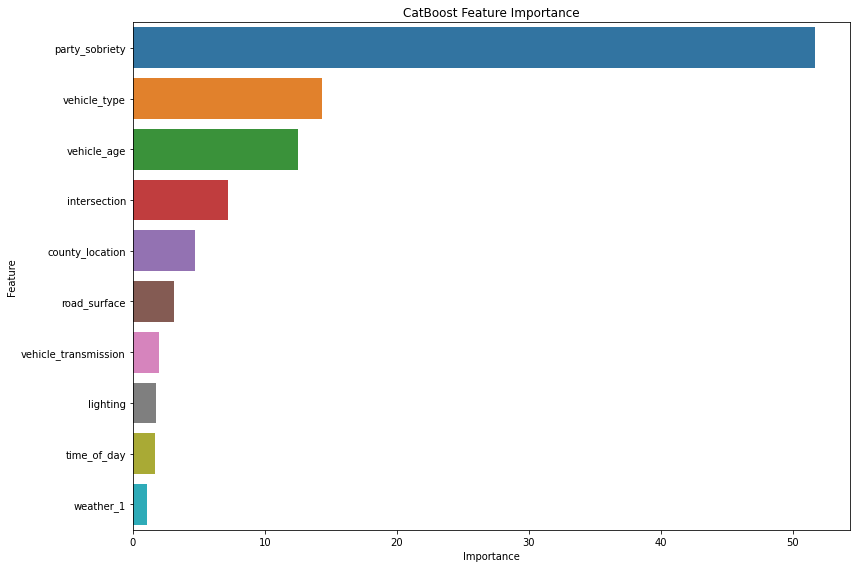


Top 20 Features:


,Feature,Importance
5,party_sobriety,51.713536
7,vehicle_type,14.324867
6,vehicle_age,12.520723
4,intersection,7.171217
3,county_location,4.663873
1,road_surface,3.117626
8,vehicle_transmission,1.958943
2,lighting,1.770247
9,time_of_day,1.698497
0,weather_1,1.060472


In [184]:
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)


plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('CatBoost Feature Importance')
plt.tight_layout()
plt.show()


print("\nTop 20 Features:")
display(importance_df.head(20))

`party_sobriety`
- Самый влиятельный фактор — трезвость водителя. Модель явно учитывает, что трезвые водители реже бывают виноваты в ДТП.

`vehicle_type`
- Тип авто влияет на дтп. Возможно более управляемые машины снижают риск дтп

`vehicle_age` 2/3 года
- Возраст авто — значимый фактор. Необходимо проверять авто на ТО

`intersection` 
- На перекрестках более упорядоченное движение и риск дтп снижается

`county_location` 
- Есть города, где риск дтп выше.

Практические выводы для задачи:
1. Трезвость водителя — главный фактор. Рекомендуется:

- Усилить проверки на алкоголь

- Добавить алкотестеры в автомобили

2. Тип Авто и возраст:

- Ситсема проверки последнего ТО

- Исправность авто

- Сравнить модели, которые возможно хуже управляются

3. Города

- Принять меры для аварийных городов, сообщить правительству длярегулирования дорожного движения:

- Предупреждение о высокой аварийности в данном городе

## Выводы

<div  style="border-radius: 10px; box-shadow: 2px 2px 2px; border: 1px solid; padding: 10px ">

**Лучшая модель:**  
    
1. **CatBoost**
    - **Accuracy** - После настройки порогов 0.6439
    - **f1_score** - 0.6155  
    
2. На втором месте оказался `Random forest` и `LogisticRegression`.   
    
    
*Текущий потенциал системы*:  
На основе представленных данных можно создать базовую работоспособную систему оценки рисков, но с существенными ограничениями:

**плюсы** 
    
    - Достаточная точность (64%) для первоначального скрининга       
    - Выявлены ключевые факторы риска: трезвость водителя, тип столкновения, возраст авто, ключевые нарушения 
         

**Возможность внедрения**:  
Систему можно использовать как дополнительный инструмент поддержки решений, но не как автономный механизм блокировки выдачи авто.

---

    
Факторы для улучшения модели

1. **Дополнительные данные о водителе**
    
   - История нарушений ПДД за последние 3 года  
   - Стаж вождения и частота использования каршеринга  
   - Биометрические показатели при посадке (усталость, стресс)  

2. **Технические параметры авто**
    
   - Датчики тормозной системы и состояние шин  
   - Результаты последнего ТО

3. **Контекстные и поведенческие данные**  
    
   - Плотность трафика в районе выдачи авто
   - Стиль вождения в первые 5 минут поездки (агрессивные разгоны/торможения)
   - Частота использования ассистентов вождения
   - Статистика по предыдущим поездкам (средняя скорость, нарушения)
